In [1]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
# Load the saved model and tokenizer
loadstr = '/home/ubuntu/bstadt-tlm/tlm/tlm-2025-08-05_16-42-11/checkpoint-10500/'
model = AutoModelForMaskedLM.from_pretrained(loadstr)
tokenizer = AutoTokenizer.from_pretrained(loadstr)

In [2]:
import sys
sys.path.append('../')
from loader import COCATokenizedDataset
dataset = COCATokenizedDataset(root_path='../coca_tokenized_ettin_large', debug=False)

Loaded file ../coca_tokenized_ettin_large/text_acad_1990.jsonl with length 13176
Loaded file ../coca_tokenized_ettin_large/text_acad_1991.jsonl with length 13444
Loaded file ../coca_tokenized_ettin_large/text_acad_1992.jsonl with length 13474
Loaded file ../coca_tokenized_ettin_large/text_acad_1993.jsonl with length 13998
Loaded file ../coca_tokenized_ettin_large/text_acad_1994.jsonl with length 13667
Loaded file ../coca_tokenized_ettin_large/text_acad_1995.jsonl with length 13592
Loaded file ../coca_tokenized_ettin_large/text_acad_1996.jsonl with length 13882
Loaded file ../coca_tokenized_ettin_large/text_acad_1997.jsonl with length 15004
Loaded file ../coca_tokenized_ettin_large/text_acad_1998.jsonl with length 13744
Loaded file ../coca_tokenized_ettin_large/text_acad_1999.jsonl with length 13426
Loaded file ../coca_tokenized_ettin_large/text_acad_2000.jsonl with length 13727
Loaded file ../coca_tokenized_ettin_large/text_acad_2001.jsonl with length 13268
Loaded file ../coca_tokenize

In [3]:
from tqdm import tqdm
import torch
def mine_uses(token, tokenizer):
    uses = []
    target_id = tokenizer.encode(token)[1]
    for elem in tqdm(dataset):
        if torch.any(elem['input_ids']==target_id):
           uses.append(elem) 
    return uses

In [4]:
cell_uses = mine_uses('cell', tokenizer)

100%|██████████| 2746160/2746160 [03:59<00:00, 11449.99it/s]


In [5]:
import re
decoded_uses = []
pattern = re.compile(r'\bcell\b')
for use in cell_uses:
    decoded = tokenizer.decode(use['input_ids'])
    match = pattern.search(decoded)
    if match:
        decoded_uses.append(decoded)

In [6]:
decoded_uses

['[YEAR:1990] in that of capacitation, " the process by which sperm become capable of fertilizing eggs. " 7 Human sperm need to be in the female reproductive tract for about seven hours before they are ready to fertilize the egg. This process removes or deactivates " a so-called decapacitating factor that binds to sperm as they pass through the male reproductive tract. " 8 This permits the acrosome reaction to occur, which is the means by which Iytic enzymes in the sperm " are released so that they can facilitate the passage of the sperm through the egg coverings. " 9 Then the sperm are able to penetrate the egg so fertilization can begin.   Fertilization usually occurs in the end of the Fallopian [MASK_NOLOSS] hours to reach the egg, and if not " fertilized within 24 hours after ovulation, it dies. " 10 Fertilization, however, is not just a simple penetration of the surface of the egg. Rather, it is a complex biochemical process in which a sperm gradually penetrates various layers of 

In [7]:
from collections import defaultdict
uses_by_year = defaultdict(lambda: 0)
for use in decoded_uses:
    year = use.split(']')[0][-4:]
    uses_by_year[year] = uses_by_year[year] + 1

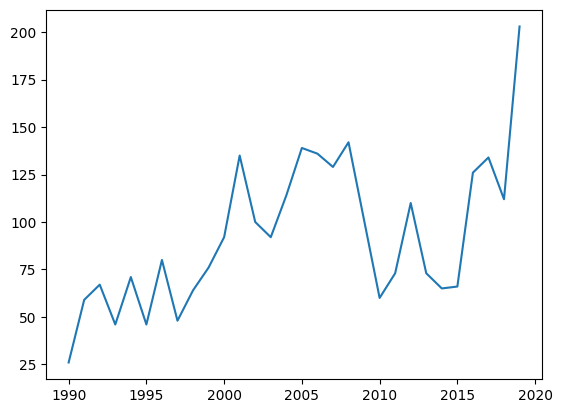

In [8]:
from matplotlib import pyplot as plt
plt.figure()
years = list(range(1990, 2020))
plt.plot(years, [uses_by_year[str(y)] for y in years])
plt.show()

In [9]:
import torch
import torch.nn.functional as F
def lyear(phrase, model, tokenizer):
    model.eval()

    years = list(range(1990, 2020))
    year_fills = ['[YEAR:{}]'.format(year) for year in years]
    year_fill_token_ids = [tokenizer.encode(e)[1] for e in year_fills]
    year_template = '[MASK] ' + phrase
    
    input_ids = tokenizer.encode(year_template, add_special_tokens=False, return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids=input_ids)
        logits = outputs.logits[0][0]
        year_sublogits = logits[year_fill_token_ids]
        year_subprobs = F.softmax(year_sublogits, dim=0)

    return years, year_sublogits, year_subprobs

In [10]:
from matplotlib import pyplot as plt
def pyear_given_slotfill(phrase, template, model, tokenizer, title, annotate=None, annotate_text=None):
    years, fill_year_logits, fill_year_probs = lyear(phrase, model, tokenizer)
    _, template_year_logits, template_year_probs = lyear(template, model, tokenizer)
    bayes_factors = fill_year_probs/template_year_probs

    plt.figure()
    plt.title(title)
    plt.ylabel('Bayes Factor')
    plt.xlabel('Year')
    plt.plot(years, bayes_factors)
    plt.legend()

    if annotate != None:
        plt.axvspan(annotate[0], annotate[1], alpha=0.3, color='green')
        if annotate_text != None:
            plt.text(annotate[0], 0, annotate_text, ha='left', va='bottom')


    plt.show()

In [11]:
from tqdm import tqdm
all_bayes_factors = []
for use in tqdm(decoded_uses):
    idx = use.find('cell')
    start = max(0, idx - 100)
    end = idx + len('cell') + 100
    phrase = use[start:end]
    template = phrase[:].replace(' cell ', ' [MASK_NOLOSS] ')
    years, fill_year_logits, fill_year_probs = lyear(phrase, model, tokenizer)
    _, template_year_logits, template_year_probs = lyear(template, model, tokenizer)
    bayes_factors = fill_year_probs/template_year_probs
    all_bayes_factors.append(bayes_factors)

100%|██████████| 2785/2785 [07:35<00:00,  6.11it/s]


In [12]:
import numpy as np
log_bf = np.log(np.array(all_bayes_factors))


In [13]:
log_bf_diff = np.sqrt(np.pow(log_bf[:, None, :] - log_bf[None, :, :], 2).sum(axis=-1))
log_bf_diff.shape 

(2785, 2785)

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Compute t-SNE embedding from the distance matrix
tsne = TSNE(metric='precomputed', random_state=42, init='random')
tsne_embedding = tsne.fit_transform(log_bf_diff)

phrases = []
for use in decoded_uses:
    idx = use.find('cell')
    start = max(0, idx - 100)
    end = idx + len('cell') + 100
    phrase = use[start:end]
    phrases.append(phrase)

import plotly.express as px

fig = px.scatter(
    x=tsne_embedding[:, 0],
    y=tsne_embedding[:, 1],
    hover_name=phrases,
    labels={'x': 't-SNE 1', 'y': 't-SNE 2'},
    title='t-SNE of "cell" contexts (hover for phrase)'
)
fig.update_traces(marker=dict(size=8, opacity=0.7))
fig.show()
